In [3]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import joblib

chargement des données

In [5]:
# Charger les données
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Projet_IA/df_clean.csv")

Mounted at /content/drive


Préparation des données

In [6]:

# On garde les colonnes utiles
features = [ 'StatusLabel', 'Length', 'Width', 'Draft', 'Cargo']
target = 'VesselTypeGroup'
X = df[features]
y = df[target]

# Séparation colonnes numériques et catégorielles
numeric_features = ['Length', 'Width', 'Draft', 'Cargo']
categorical_features = ['StatusLabel']

# Pipeline de transformation
numeric_transformer = StandardScaler() #Applique une standardisation (centrage-réduction) aux colonnes numériques (moyenne = 0, écart-type = 1)
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # Applique un OneHotEncoder pour la transformer en colonnes binaires

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Pipeline complète
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Préparation
X_prepared = pipeline.fit_transform(X)

# Division des données
X_train, X_test, y_train, y_test = train_test_split(
    X_prepared, y, test_size=0.2, random_state=42, stratify=y)

# Sauvegarde de la prépa de données
joblib.dump(pipeline, 'preprocessor.joblib')

['preprocessor.joblib']

test du traitement de données

In [7]:
print(X_prepared.shape) #4 variables numériques et 5 catégorielles car 5 catégories dans "StatusLabel"
print(X_train.shape, X_test.shape) #verification du split entre les variables train/test
print(y_train.shape, y_test.shape)


(169566, 9)
(135652, 9) (33914, 9)
(135652,) (33914,)


régression logistique multinomiale

In [8]:

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [9]:

# Évaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 2444     0     0]
 [    0 13454  1442]
 [    0     0 16574]]
              precision    recall  f1-score   support

          60       1.00      1.00      1.00      2444
          70       1.00      0.90      0.95     14896
          80       0.92      1.00      0.96     16574

    accuracy                           0.96     33914
   macro avg       0.97      0.97      0.97     33914
weighted avg       0.96      0.96      0.96     33914



Métriques

Accuracy: 0.9574806864421773
              precision    recall  f1-score   support

          60       1.00      1.00      1.00      2444
          70       1.00      0.90      0.95     14896
          80       0.92      1.00      0.96     16574

    accuracy                           0.96     33914
   macro avg       0.97      0.97      0.97     33914
weighted avg       0.96      0.96      0.96     33914



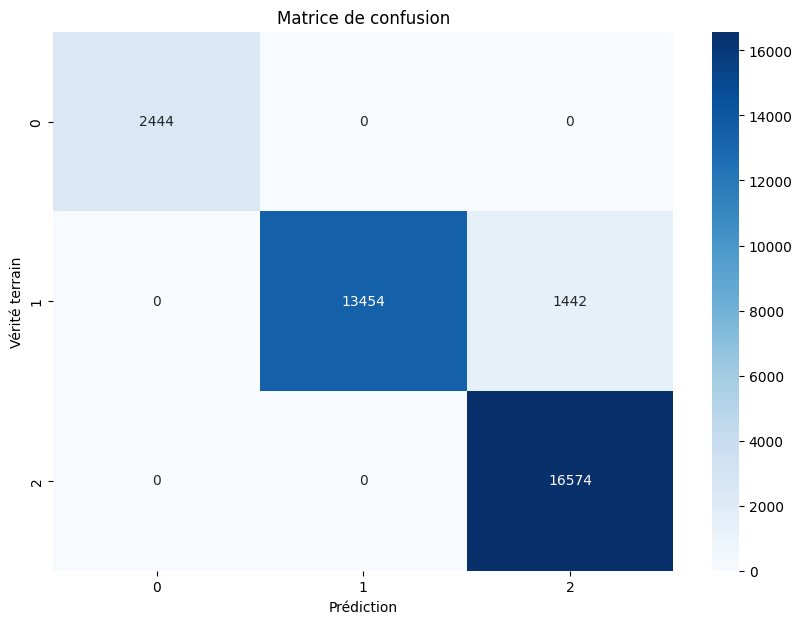

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Prédiction sur le jeu test
y_pred = clf.predict(X_test)

# Accuracy globale
print("Accuracy:", accuracy_score(y_test, y_pred))

# Rapport détaillé (precision, recall, f1)
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion')
plt.show()


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
# 4 (C) × 2 (solver) × 3 (max_iter) = 24 tests différents
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 200, 500],
    'multi_class': ['multinomial']
}


# GridSearchCV avec validation croisée 5-fold
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1) # cv: découpage des données en 5 sous parties (4train 1test), on prend la meilleur accuracy

'''
Pour chaque combinaison, il fait une validation croisée :
Découpe les données d’entraînement en 5 sous-parties (si cv=5).
Il entraîne le modèle sur 4 sous-parties et teste sur la 5ème.
Il répète l’opération pour les 5 sous-parties.
Il calcule la moyenne de la performance ici accuracy
'''

# Entraînement sur données d'apprentissage
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print("Les meilleurs paramètres sont:", grid_search.best_params_)

# Meilleur score (accuracy)
print("Meilleur score:", grid_search.best_score_)

# Prédictions avec le meilleur modèle
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Évaluation finale
print(classification_report(y_test, y_pred))


#sauvegarde
joblib.dump(grid_search, 'gridsearch_logistic.pkl')


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Les meilleurs paramètres sont: {'C': 0.01, 'max_iter': 100, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
Meilleur score: 0.9585114710740585
              precision    recall  f1-score   support

          60       1.00      1.00      1.00      2444
          70       1.00      0.90      0.95     14896
          80       0.92      1.00      0.96     16574

    accuracy                           0.96     33914
   macro avg       0.97      0.97      0.97     33914
weighted avg       0.96      0.96      0.96     33914



['gridsearch_logistic.pkl']

In [13]:
# Chargement du GridSearchCV sauvegardé
loaded_grid_search = joblib.load('gridsearch_logistic.pkl')

# Utilisation directe
best_clf = loaded_grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

print("Les meilleurs paramètres chargés:", loaded_grid_search.best_params_)
print("Meilleur score chargé:", loaded_grid_search.best_score_)
print(classification_report(y_test, y_pred))


Les meilleurs paramètres chargés: {'C': 0.01, 'max_iter': 100, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
Meilleur score chargé: 0.9585114710740585
              precision    recall  f1-score   support

          60       1.00      1.00      1.00      2444
          70       1.00      0.90      0.95     14896
          80       0.92      1.00      0.96     16574

    accuracy                           0.96     33914
   macro avg       0.97      0.97      0.97     33914
weighted avg       0.96      0.96      0.96     33914



SVM

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Division des données brutes (DataFrame, pas encore transformées)
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Pipeline complet SVM
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),   # pas X_prepared ici, on prétraite dans le pipeline
    ('classifier', SVC())
])

# Grille d'hyperparamètres
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

# GridSearchCV
grid_search_svm = GridSearchCV(
    svm_pipeline,
    param_grid_svm,
    cv=3,            # Réduit si nécessaire (moins de calcul)
    n_jobs=-1,
    verbose=2
)

# Entraînement avec les données brutes (non transformées)
grid_search_svm.fit(X_train_df, y_train)

# Évaluation
print("Best params:", grid_search_svm.best_params_)
y_pred_svm = grid_search_svm.predict(X_test_df)
print(classification_report(y_test, y_pred_svm))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
              precision    recall  f1-score   support

          60       1.00      1.00      1.00      2444
          70       1.00      1.00      1.00     14896
          80       1.00      1.00      1.00     16574

    accuracy                           1.00     33914
   macro avg       1.00      1.00      1.00     33914
weighted avg       1.00      1.00      1.00     33914



In [16]:
#sauvegarde
joblib.dump(grid_search, 'gridsearch_SVM.pkl')


['gridsearch_SVM.pkl']

In [17]:
# Chargement du GridSearchCV sauvegardé
loaded_grid_search = joblib.load('gridsearch_SVM.pkl')

# Utilisation directe
best_clf = loaded_grid_search.best_estimator_
y_pred_svm = best_clf.predict(X_test)

print("Les meilleurs paramètres chargés:", loaded_grid_search.best_params_)
print("Meilleur score chargé:", loaded_grid_search.best_score_)
print(classification_report(y_test, y_pred_svm))


Les meilleurs paramètres chargés: {'C': 0.01, 'max_iter': 100, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
Meilleur score chargé: 0.9585114710740585
              precision    recall  f1-score   support

          60       1.00      1.00      1.00      2444
          70       1.00      0.90      0.95     14896
          80       0.92      1.00      0.96     16574

    accuracy                           0.96     33914
   macro avg       0.97      0.97      0.97     33914
weighted avg       0.96      0.96      0.96     33914



heatmap

<Figure size 800x600 with 0 Axes>

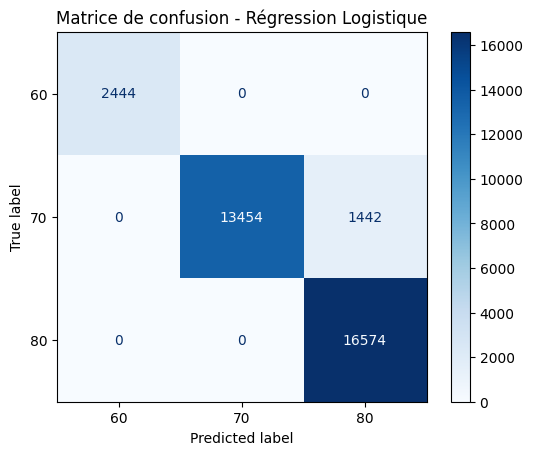

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


ValueError: could not convert string to float: 'Amarré [5]'

<Figure size 800x600 with 0 Axes>

In [22]:
import joblib
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --------- Régression Logistique ---------
# Chargement du modèle GridSearchCV pour la régression logistique
grid_search_log = joblib.load('gridsearch_logistic.pkl')

# Matrice de confusion - Logistic Regression
plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(
    grid_search_log.best_estimator_,
    X_test,          # Données déjà transformées
    y_test,
    cmap='Blues'
)
plt.title("Matrice de confusion - Régression Logistique")
plt.grid(False)
plt.show()


# --------- SVM ---------
# Chargement du modèle GridSearchCV pour le SVM
grid_search_svm = joblib.load('gridsearch_SVM.pkl')



# Matrice de confusion - SVM
plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(
    grid_search_svm.best_estimator_,
    X_test_df,      # Données brutes car pipeline complet dans le modèle
    y_test,
    cmap='Greens'
)
plt.title("Matrice de confusion - SVM")
plt.grid(False)
plt.show()
